In [1]:
import pandas as pd
import pickle
import numpy as np
import re
from datetime import datetime
from dateutil import parser
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import statsmodels.api as sm
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

pd.set_option("display.max_rows", 500)

The function prep_data takes the following inputs:
    - player level dataset
    - dictionary, which relates the features to be used to lists of lags, which should be constructed for each feature

In [2]:
def prep_data(player_df, feats_lags_dict):
    
    player_df['homeoraway'] = player_df['home'].map({1: 'home', 0: 'away'})

    team_vars = ['league', 'season', 'matchid', 'date', 'start_time', 'tackles', 'weekday',
             'result', 'goals', 'team_name', 'possession', 'opp_goals', 'homeoraway', 'air_duel_rate', 
             'dribbles_won', 'pass_succ', 'shots', 'shots_ot']

    player_vars = [x for x in player_df.columns if x[:2] == 'p_']

    pos_dict = {'GK': 'gk', 
            'DL': 'd', 'DR': 'd', 'DC': 'd', 
            'MC': 'm', 'ML': 'm', 'MR': 'm', 'DMC': 'm', 'AMC': 'm', 'AML': 'm', 'AMR': 'm', 'AMC': 'm', 'DML': 'm', 'DMR': 'm',
            'FW': 'a', 'FWL': 'a', 'FWR': 'a',
            'Sub': 'sub'}
    player_df['p_agg_pos'] = player_df.p_position.map(pos_dict)

    pos_df = player_df.groupby(['matchid', 'team_name', 'p_agg_pos'])[player_vars].agg(np.mean).unstack()
    pos_df.columns = ['_'.join(col).strip() for col in pos_df.columns.values]

    team_df = player_df[team_vars].groupby(['matchid', 'team_name']).first()

    team_df['result_num'] = team_df['result'].map({'W': 2, 'D': 1, 'L': 0})
    team_df['win'] = team_df.groupby(['team_name', 'season'])['result_num'].apply(lambda x: x == 2)*1
    team_df['draw'] = team_df.groupby(['team_name', 'season'])['result_num'].apply(lambda x: x == 1)*1

    prev_wins = team_df.groupby(['team_name', 'season'])['win'].transform(lambda x: x.cumsum())
    nr_games = team_df.groupby(['team_name', 'season']).cumcount() + 1
    team_df['win_pct'] = prev_wins/nr_games

    team_df_t = pd.concat([team_df, pos_df], axis = 1)
    team_df_t.reset_index(drop = False, inplace = True)
    team_df_t.sort_values('date', inplace = True)
    
    est_table = pd.DataFrame(team_df_t[['matchid', 'league', 'season', 'homeoraway', 'team_name', 'result_num', 
                                        'date', 'goals']])

    for feat in feats_lags_dict.keys():
        for lag in feats_lags_dict[feat]:
            est_table[feat + '_lag_' + str(lag)] = get_lagged_feature(lag, feat, team_df_t)        

    est_table.set_index(['matchid', 'homeoraway'], inplace = True, drop = True)
    match_df = est_table.unstack('homeoraway')
    match_df.columns = ['_'.join(col).strip() for col in match_df.columns.values]
    match_df.reset_index(drop = False, inplace = True)
    
    feature_list = [feat for feat in match_df.columns if '_lag_' in feat]
    mask = ~ match_df[feature_list].isnull().any(axis=1)

    features = np.array(match_df[mask][feature_list])
    labels = np.array(match_df[mask]['result_num_home'])
    
    match_df['date'] = match_df['date_home']
    match_df['league'] = match_df['league_home']
    match_df['season'] = match_df['season_home']
    
    meta_data_vars = ['matchid', 'team_name_away', 'team_name_home', 'date', 
                      'result_num_home', 'goals_home', 'goals_away', 'season', 'league']
    
    meta_data = pd.DataFrame(match_df[mask][meta_data_vars])
    
    return features, labels, meta_data

In [3]:
def get_lagged_feature(lag, feat, team_data):
    grouped = team_data.groupby(['team_name', 'season'])
    lagged_feat = grouped[feat].transform(lambda x: x.shift(lag))
    lagged_feat.name = feat + '_lag_' + str(lag)
    return lagged_feat

In [4]:
def eval_model(league, y_test, y_pred, labels = [2, 1, 0]):
    conf = confusion_matrix(y_test, y_pred, labels = [2, 1, 0])
    print(league)
    print(conf)
    print('Overall Accuracy: ' + str(np.round(accuracy_score(y_test, y_pred),3)))
    print('\n')
    print('Home Win Accuracy: ' + str(np.round(conf[0][0]/conf[0].sum(),3)))
    print('Draw Accuracy: ' + str(np.round(conf[1][1]/conf[1].sum(),3)))
    print('Away Win Accuracy: ' + str(np.round(conf[2][2]/conf[2].sum(),3)))
    print('\n')
    print('Number of Features used: ' + str(features.shape[1]))
    print('\n')

In [7]:
def calc_return(pred_probs, betting_odds, betting_cutoff, true_results):

    diff_probs = pred_probs - 1/betting_odds

    betting_mask = diff_probs > betting_cutoff
    nr_bets = betting_mask.sum()

    if nr_bets > 0:
        revenue = ((np.array(true_results)[betting_mask] == 2)*betting_odds[betting_mask]).sum()
        roi = (revenue - nr_bets)*100/nr_bets
        
        return roi, nr_bets/len(pred_probs)
    else:
        return np.nan, np.nan

# Load Data

In [10]:
df = pickle.load(open("player_level.pckl", "rb"))

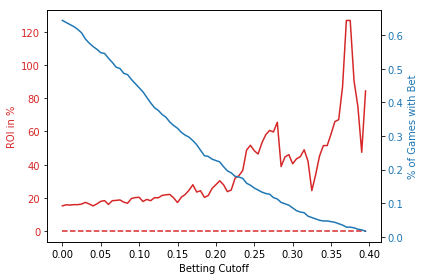

In [20]:
feats_lags_dict = {'win_pct': [1], 'win': [1,2,3], 'goals': [1,2,3], 'opp_goals': [1,2,3]}
cutoff_date = '2018-08-01'
leagues = ['prem_league']
league = leagues[0]

train_test_df = pd.DataFrame(df.loc[(df.league == league) & (df.date < cutoff_date)])
eval_df = pd.DataFrame(df.loc[(df.league == league) & (df.date > cutoff_date)])

features, labels, meta_data = prep_data(train_test_df, feats_lags_dict)
features_eval, labels_eval, meta_data_eval = prep_data(eval_df, feats_lags_dict)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels) 

pipe_lr = make_pipeline(StandardScaler(), 
                        #PCA(25),
                        LogisticRegression(multi_class = 'auto', solver = 'lbfgs')
                        ) 

pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)

#eval_model(league, y_test, y_pred, labels = [2, 1, 0])

logreg = pipe_lr.named_steps['logisticregression']
pred_probs = logreg.predict_proba(features_eval)

team_dict = {'Man City': 'Manchester City', 'Man United': 'Manchester United', 'West Brom': 'West Bromwich Albion',
             'QPR': 'Queens Park Rangers', 'Wolves': 'Wolverhampton Wanderers', 'Newcastle': 'Newcastle United',
             'Milan': 'AC Milan', 'Siena': 'Robur Siena',
             'Dortmund': 'Borussia Dortmund', 'Hertha': 'Hertha Berlin', 'Mainz': 'Mainz 05', 'Nurnberg': 'Nuernberg',
             'Ein Frankfurt': 'Eintracht Frankfurt', 'FC Koln': 'FC Cologne', 'Hamburg': 'Hamburger SV', 
             'Hannover': 'Hannover 96', 'Leverkusen': 'Bayer Leverkusen', 'Stuttgart': 'VfB Stuttgart', 
             "M'gladbach": 'Borussia M.Gladbach', 'Greuther Furth': 'Greuther Fuerth', 
             'Fortuna Dusseldorf': 'Fortuna Duesseldorf', 'Braunschweig': 'Eintracht Braunschweig',
             'RB Leipzig': 'RasenBallsport Leipzig'}

odds_vars = ['B365H', 'B365D', 'B365A']
meta_data_odds = ['league', 'season', 'team_name_home', 'team_name_away']

odds_df = pd.DataFrame()

for season_odds in meta_data_eval.season.unique():

    temp_df = pd.read_csv(
        'C:/Users/peter/Google Drive/Football/odds_data/' + league + '_' + season_odds + '.csv', index_col=False)

    temp_df['league'] = league
    temp_df['season'] = season_odds

    temp_df['team_name_home'] = temp_df.HomeTeam.map(team_dict).fillna(temp_df['HomeTeam'])
    temp_df['team_name_away'] = temp_df.AwayTeam.map(team_dict).fillna(temp_df['AwayTeam'])

    temp_df.dropna(axis = 0, how = 'any', inplace = True)

    odds_df = odds_df.append(temp_df[meta_data_odds + odds_vars], sort = False)

merged_df = meta_data_eval.merge(odds_df, how = 'left', on = ['league', 'season', 'team_name_home', 'team_name_away'])

for var in odds_vars:
    merged_df[var + '_prob'] = 1/merged_df[var]

x = np.arange(0,0.4,0.005)

roi = [calc_return(pred_probs[:,2], merged_df['B365H'], y, meta_data_eval.result_num_home)[0] for y in x]
perc_bet = [calc_return(pred_probs[:,2], merged_df['B365H'], y, meta_data_eval.result_num_home)[1] for y in x]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Betting Cutoff')
ax1.set_ylabel('ROI in %', color=color)
ax1.plot(x, roi, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(x, [0]*len(x), color = color, linestyle = '--')

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('% of Games with Bet', color=color)
ax2.plot(x, perc_bet, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# Grid Search

In [164]:
    param_grid = {'logisticregression__C': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1],
                  'pca__n_components': [3,5,8,10,12,15,20,25,30,40,50]}
    
    gs = GridSearchCV(estimator = pipe_lr,
                      param_grid = param_grid,
                      scoring = 'accuracy',
                      cv = 10,
                      n_jobs = -1)
    
    gs = gs.fit(X_train, y_train)
    
    print(str(lagloop) + ' lags used.')
    print(gs.best_score_)
    print(gs.best_params_)
    print('\n')

1 lags used.
0.49586492074431426
{'logisticregression__C': 0.0005, 'pca__n_components': 12}


2 lags used.
0.508694109297374
{'logisticregression__C': 0.01, 'pca__n_components': 20}


3 lags used.
0.5109609061015711
{'logisticregression__C': 0.001, 'pca__n_components': 30}


4 lags used.
0.5143126177024482
{'logisticregression__C': 0.0005, 'pca__n_components': 40}


5 lags used.
0.5199145133087235
{'logisticregression__C': 0.0001, 'pca__n_components': 25}


6 lags used.
0.5197592778335005
{'logisticregression__C': 0.001, 'pca__n_components': 15}


7 lags used.
0.522289031722994
{'logisticregression__C': 1, 'pca__n_components': 30}


8 lags used.
0.5216831258050666
{'logisticregression__C': 0.0005, 'pca__n_components': 20}


9 lags used.
0.5244553134726545
{'logisticregression__C': 0.05, 'pca__n_components': 30}


10 lags used.
0.5213477959843065
{'logisticregression__C': 0.5, 'pca__n_components': 25}


11 lags used.
0.5220623501199041
{'logisticregression__C': 0.0005, 'pca__n_component

In [102]:


eval_meta_vars = ['team_name_home', 'team_name_away', 'goals_home', 'goals_away', 'result_num_home']

for outcome_idx, outcome in enumerate(['away win', 'draw', 'home win']):
    prob = pred_probs[:,outcome_idx].max()
    prob_idx = np.where(pred_probs[:,outcome_idx] == prob)
    print('Largest predicted probability for ' + outcome + ' with ' + str(np.round(prob, 3)*100) + '%:')
    print('\n')
    print(meta_data_eval.iloc[prob_idx][eval_meta_vars])
    print('\n')
    print('\n')

Largest predicted probability for away win with 41.0%:


    team_name_home team_name_away  goals_home  goals_away  result_num_home
103         Fulham      Liverpool           1           2                0




Largest predicted probability for draw with 49.8%:


   team_name_home   team_name_away  goals_home  goals_away  result_num_home
55    Bournemouth  Manchester City           0           1                0




Largest predicted probability for home win with 81.0%:


   team_name_home team_name_away  goals_home  goals_away  result_num_home
32      Tottenham       Brighton           1           0                2




